In [47]:
import pandas as pd
import numpy as np
import pickle
from sklearn import linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
# from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import confusion_matrix

import warnings,os
warnings.simplefilter('ignore')

import matplotlib as mpl
import matplotlib.dates as mdates
import datetime as dt
import csv

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

path="C:\\Users\\Admin\\Documents\\"

In [48]:
def CreateData(dataFrame):
    dataset =np.array( dataFrame.iloc[:, 0:1044])
    target = dataFrame.loc[:,['label']]
    target = np.array(target.replace(to_replace=['О', 'К'], value=[1, 0]))
    target =target.astype('int32')   
    target.transpose()
    x=np.where(np.isnan(dataset))[0]
    x=np.unique(x)
    i=0   
    for item in x:
        dataset=np.delete(dataset, item-i, axis=0)
        target=np.delete(target, item-i)
        i+=1
    return dataset,target

In [49]:
#сохранение
def saveModel(score,path,nameModel):
    save=False
    dateFile = os.listdir(path)
    name=path+ str(score)+'_'+nameModel+'.pkl'
    for item in dateFile:
        temp=item.split('_')
        if len(temp)==2:
            if (temp[1].find(nameModel)!=-1):
                if (float(temp[0])<score):
                    print("Модель",nameModel,"сохранена\n")
                    save=True
                break
    else:
        save=True
    return save,name

# StandardScaler
Идея StandardScaler заключается в том, что он преобразует данные так, что бы их распределение будет иметь среднее значение 0 и стандартное отклонение 1. Учитывая распределение данных, каждое значение в наборе данных будет вычтено из среднего значения выборки, а затем разделено на стандартное отклонение всего набора данных.

In [50]:
path="C:\\Users\\Admin\\Documents\\raman2.xlsx"
dataFrame = pd.read_excel(path)
path="C:\\Users\\Admin\\Documents\\PythonRaman\\"
x,y=CreateData(dataFrame)
train_dataset ,  test_dataset ,  train_target ,  test_target=train_test_split(x,y, test_size=0.30,stratify=y)
# normalized_train_dataset = preprocessing.normalize(train_dataset)
# normalized_test_dataset = preprocessing.normalize(test_dataset)

from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
normalized_train_dataset = scaler.fit_transform(train_dataset)
normalized_test_dataset = scaler.fit_transform(test_dataset)
spec=[]
ch=[]

# Support Vector Classification

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:   38.3s finished


0.2565597667638484 0.45 

[[ 24 110]
 [ 17 144]]
Специфичность 0.1791044776119403
Чувствительность 0.8944099378881988
--------------
f1ScoreWeighted= 0.5033369701566557
f1ScoreMacro= 0.4841308089500861
f1ScoreBinary= 0.6939759036144578
Точноть 0.5694915254237288


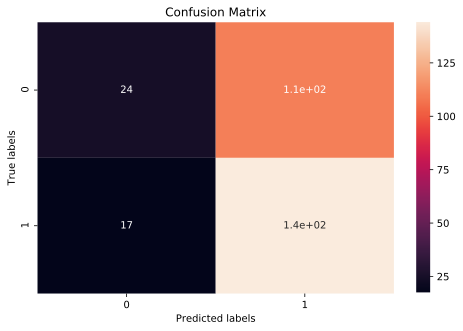

In [51]:
from sklearn.svm import NuSVC

nuSVC=NuSVC()

#GridSearchCV
#----------------------------------------------------------------------
tuned_parameters = {'nu':np.arange(.05,0.95,0.05)}
nu_svc = GridSearchCV(nuSVC,param_grid=tuned_parameters,cv=5, verbose=True)
nu_svc.fit(normalized_train_dataset, train_target)
best_parameter_nu = nu_svc.best_estimator_.nu
best_cv_err = 1 - nu_svc.best_score_
print (best_cv_err, best_parameter_nu,"\n")

#Обучение модели с оптимальными параметрами
NuSVC2 = NuSVC(gamma='scale',nu=best_parameter_nu,probability=True)
NuSVC2.fit(normalized_train_dataset, train_target)

#предсказание
expected = test_target
predicted = NuSVC2.predict(normalized_test_dataset)
predicted_NuSVC2=predicted
expected_NuSVC2_traine = train_target
predicted_NuSVC2_train = NuSVC2.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')
    

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=NuSVC2.score(normalized_test_dataset, test_target)
print('Точноть',buff_score)
Score=[buff_score]
NameModel=["nuSVC"]
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])

if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(NuSVC2, fid)

# Дерево принятия решений

Дерево принятия решений

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.35276967930029157 4 18 

[[118  16]
 [ 94  67]]
Специфичность 0.8805970149253731
Чувствительность 0.4161490683229814
--------------
f1ScoreWeighted= 0.6095487346356647
f1ScoreMacro= 0.6156306263621719
f1ScoreBinary= 0.5491803278688524
Точноть 0.6271186440677966


[Parallel(n_jobs=1)]: Done 750 out of 750 | elapsed:    7.3s finished


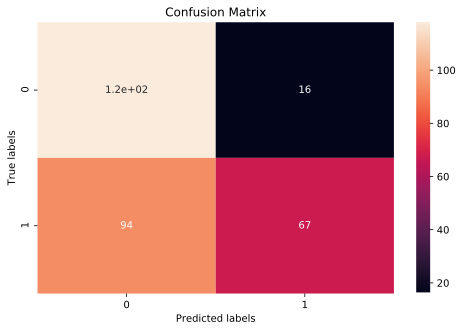

In [52]:
from sklearn.tree import DecisionTreeClassifier
#Cart
print("Дерево принятия решений\n")

#GridSearchCV
cartModel = DecisionTreeClassifier()
tuned_parameters = {'max_depth': np.arange(1,11),
                'max_features': np.arange(4,19)}
tree_grid = GridSearchCV(cartModel, tuned_parameters,cv=5, 
                         verbose=True)
tree_grid.fit(normalized_train_dataset, train_target)

best_parameter_max_depth = tree_grid.best_estimator_.max_depth
best_parameter_max_features = tree_grid.best_estimator_.max_features
best_cv_err = 1 - tree_grid.best_score_
print (best_cv_err, best_parameter_max_depth,best_parameter_max_features,"\n")

#Обучение модели с оптимальными параметрами
cartModel = DecisionTreeClassifier(max_depth=best_parameter_max_depth,
                                   max_features=best_parameter_max_features)
cartModel.fit(normalized_train_dataset, train_target)

#предсказание
expected = test_target
predicted = cartModel.predict(normalized_test_dataset)
predicted_cartModel=predicted
expected_cartModel_traine = train_target
predicted_cartModel_train = cartModel.predict(normalized_train_dataset)


#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=cartModel.score(normalized_test_dataset, test_target)
print('Точноть',buff_score)
Score.append(buff_score)
NameModel.append("cartModel")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])

if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(cartModel, fid)

# Логическая регрессия

Логическая регрессия

0.2274052478134111 107 

[[ 50  84]
 [ 23 138]]
Специфичность 0.373134328358209
Чувствительность 0.8571428571428571
--------------
f1ScoreWeighted= 0.6127294482893821
f1ScoreMacro= 0.6018592096466997
f1ScoreBinary= 0.7206266318537858
Точноть 0.6372881355932203


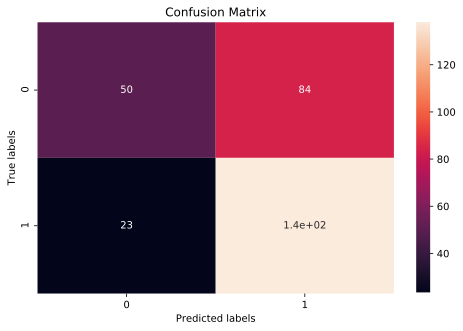

In [53]:
from sklearn.linear_model import LogisticRegression
#Логическая регрессия
print("Логическая регрессия\n")

#GridSearchCV
tuned_parameters = {'C': list(range(1,150))}
grid = GridSearchCV(LogisticRegression(solver='liblinear'), tuned_parameters, 
                   cv=5, scoring="accuracy")
grid.fit(normalized_train_dataset, train_target)

best_cv_err2 = 1 - grid.best_score_
best_parameter = grid.best_estimator_.C
print (best_cv_err2, best_parameter,"\n")

#Обучение модели с оптимальными параметрами
lgModel = LogisticRegression(C=best_parameter)
lgModel.fit(normalized_train_dataset, train_target)

expected = test_target
predicted = lgModel.predict(normalized_test_dataset)
predicted_lgModel=predicted
expected_lgModel_traine = train_target
predicted_lgModel_train = lgModel.predict(normalized_train_dataset)

#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 

f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=lgModel.score(normalized_test_dataset, test_target)
print('Точноть',buff_score)
Score.append(buff_score)
NameModel.append("lgModel")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(lgModel, fid)

# Создание модели КNN

КNN

0.3032069970845481 14 

[[102  32]
 [ 73  88]]
Специфичность 0.7611940298507462
Чувствительность 0.546583850931677
--------------
f1ScoreWeighted= 0.641714837521089
f1ScoreMacro= 0.6432643471651176
f1ScoreBinary= 0.6263345195729537
Точноть 0.6440677966101694


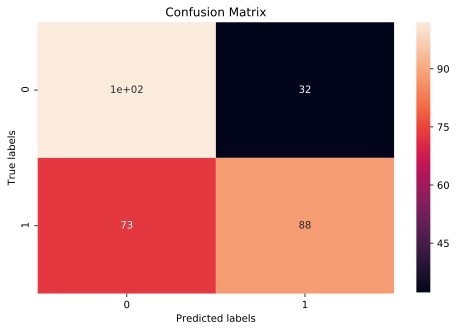

In [54]:
#Создание модели КNN
from sklearn.neighbors import KNeighborsClassifier
print("КNN\n")
#----------------------------------------------------------------------
#GridSearchCV
tuned_parameters= list(range(1,30))
knnModel = KNeighborsClassifier()
grid = GridSearchCV(knnModel, param_grid={'n_neighbors': tuned_parameters},cv=5)
grid.fit(normalized_train_dataset, train_target)

best_cv_err = 1 - grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print (best_cv_err, best_n_neighbors,"\n")
#----------------------------------------------------------------------
#Обучение модели с оптимальными параметрами

knnModel = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knnModel.fit(normalized_train_dataset, train_target)

expected = test_target
predicted = knnModel.predict(normalized_test_dataset)
predicted_knnModel=predicted

expected_knnModel_traine = train_target
predicted_knnModel_train = knnModel.predict(normalized_train_dataset)
#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(expected, predicted_knnModel)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')   

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)
      
f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=knnModel.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("knnModel")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(knnModel, fid)

# Случайный лес

err= 0.30903790087463556  best_n_estimators= 29  max_features= 3 

[[ 43  91]
 [ 31 130]]
Специфичность 0.3208955223880597
Чувствительность 0.8074534161490683
--------------
f1ScoreWeighted= 0.5592711796145995
f1ScoreMacro= 0.5470449053564237
f1ScoreBinary= 0.6806282722513088
Точноть 0.5864406779661017


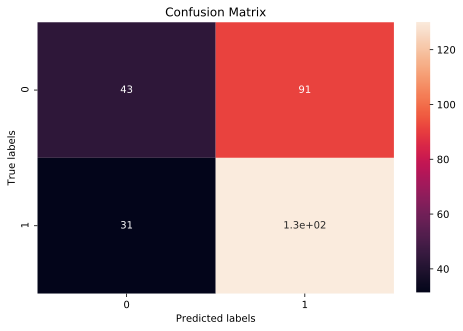

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from sklearn.metrics import roc_auc_score         
#----------------------------------------------------------------------
#GridSearchCV
RDF_model = ensemble.RandomForestClassifier()
tuned_parameters={'n_estimators': np.arange(10,100),'max_features':np.arange(1,5)}
grid = GridSearchCV(RDF_model, param_grid=tuned_parameters,cv=5)
grid.fit(normalized_train_dataset, train_target)

best_cv_err = 1 - grid.best_score_
best_n_estimators = grid.best_estimator_.n_estimators
best_max_features = grid.best_estimator_.max_features
print ('err=',best_cv_err, " best_n_estimators=",best_n_estimators, " max_features=",best_max_features,"\n")
#----------------------------------------------------------------------
#Обучение модели с оптимальными параметрами

RDF_grid_model = RandomForestClassifier(n_estimators=best_n_estimators,max_features=best_max_features,oob_score=True,)
RDF_grid_model.fit(normalized_train_dataset, train_target)

expected = test_target
predicted_RDF = RDF_grid_model.predict(normalized_test_dataset)

expected_RDF_grid_traine = train_target
predicted_RDF_grid_train = RDF_grid_model.predict(normalized_train_dataset)
#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(test_target, predicted_RDF)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted=f1_score(test_target, predicted_RDF, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted_RDF, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)
      
f1ScoreBinary=f1_score(test_target, predicted_RDF, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=RDF_grid_model.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("RDF")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(RDF_grid_model, fid)

In [56]:
# print("RandomForestRegressor")
# """
# RandomForestRegressor
# """
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import roc_auc_score
# RDF3 =  RandomForestRegressor(n_estimators=48 ,
#                                oob_score=True,
#                                random_state=1)

# RDF3.fit(normalized_train_dataset, train_target)
# a = RDF3.predict(normalized_test_dataset)

# print ("AUC-ROC (oob) = ", roc_auc_score(train_target, RDF3.oob_prediction_))
# print ("AUC-ROC (test) = ", roc_auc_score(test_target, a))

# Наивный Байес

Наивный Байес

[[129   5]
 [132  29]]
Специфичность 0.9626865671641791
Чувствительность 0.18012422360248448
--------------
f1ScoreWeighted= 0.45902111905115556
f1ScoreMacro= 0.47530022719896137
f1ScoreBinary= 0.29743589743589743
Точноть 0.535593220338983


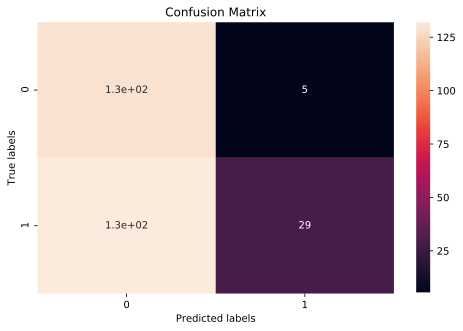

In [57]:
#Использование модели Наивный Байес
print("Наивный Байес\n")
from sklearn.naive_bayes import GaussianNB
#----------------------------------------------------------------------

nbModel = GaussianNB()
nbModel.fit(normalized_train_dataset, train_target)

expected = test_target
predicted = nbModel.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(expected, predicted)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------') 

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результы
f1ScoreWeighted=f1_score(test_target, predicted, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)

f1ScoreBinary=f1_score(test_target, predicted, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=nbModel.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("nbModel")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(nbModel, fid)

# Взвешенное голосование
RDF NuSVC2 knn lg cart nbModel

0.7871720116618076
0.8119533527696793
0.8294460641399417 

0.6338983050847458
0.6508474576271186
0.688135593220339 

[[111  23]
 [ 69  92]]
Специфичность 0.8283582089552238
Чувствительность 0.5714285714285714
--------------
f1ScoreWeighted= 0.6849904638526035
f1ScoreMacro= 0.6868365180467091
f1ScoreBinary= 0.6666666666666666
Точноть 0.688135593220339
Модель VotingClassifier1 сохранена



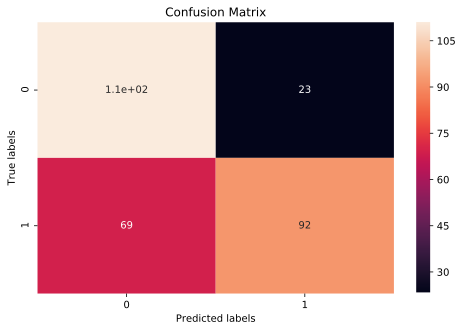

In [58]:
eclf1 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel), 
                                     ('lg', lgModel),('cart', cartModel),('nbModel',nbModel)], 
                                     voting='hard')
eclf1 = eclf1.fit(normalized_train_dataset, train_target)

eclf2 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel),
                                     ('lg', lgModel),('cart', cartModel),('nbModel',nbModel)],
                                     voting='soft')
eclf2 = eclf2.fit(normalized_train_dataset, train_target)

eclf3 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel), 
                                     ('lg', lgModel),('cart', cartModel),('nbModel',nbModel)],
                                    voting='soft', flatten_transform=True)
eclf3 = eclf3.fit(normalized_train_dataset, train_target)

print(eclf1.score( normalized_train_dataset, train_target))
print(eclf2.score( normalized_train_dataset, train_target))
print(eclf3.score( normalized_train_dataset, train_target),'\n')

print(eclf1.score( normalized_test_dataset, test_target))
print(eclf2.score( normalized_test_dataset, test_target))
print(eclf3.score( normalized_test_dataset, test_target),'\n')

# Score.append(max(eclf1.score( normalized_test_dataset, test_target),
#                            eclf2.score( normalized_test_dataset, test_target),
#                            eclf3.score( normalized_test_dataset, test_target)))
expected = test_target
predicted_VotingClassifier = eclf3.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix

cm = metrics.confusion_matrix(expected, predicted_VotingClassifier)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')  

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted=f1_score(test_target, predicted_VotingClassifier, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted)

f1ScoreMacro=f1_score(test_target, predicted_VotingClassifier, average='macro')
print("f1ScoreMacro=",f1ScoreMacro)
      
f1ScoreBinary=f1_score(test_target, predicted_VotingClassifier, average='binary')
print("f1ScoreBinary=",f1ScoreBinary)

buff_score=eclf3.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("VotingClassifier1")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(eclf3, fid)

# Взвешенное голосование

RDF NuSVC2 knn lg cart


0.8542274052478134
0.934402332361516
0.9212827988338192 

0.6
0.6813559322033899
0.6949152542372882 

[[111  23]
 [ 69  92]]
Специфичность 0.8283582089552238
Чувствительность 0.5714285714285714
--------------
f1ScoreWeighted= 0.688687994458184
f1ScoreMacro= 0.6830834606569901
f1ScoreBinary= 0.7443181818181819
Точноть 0.6949152542372882
Модель VotingClassifier2 сохранена



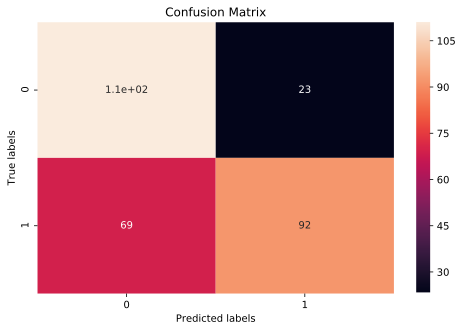

In [59]:
eclf1 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel), 
                                     ('lg', lgModel),('cart', cartModel)], 
                                     voting='hard')
eclf1 = eclf1.fit(normalized_train_dataset, train_target)

eclf2 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel),
                                     ('lg', lgModel),('cart', cartModel)],
                                     voting='soft')
eclf2 = eclf2.fit(normalized_train_dataset, train_target)

eclf3 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('NuSVC2', NuSVC2), ('knn', knnModel), 
                                     ('lg', lgModel),('cart', cartModel)],
                                    voting='soft', flatten_transform=True)
eclf3 = eclf3.fit(normalized_train_dataset, train_target)

print(eclf1.score( normalized_train_dataset, train_target))
print(eclf2.score( normalized_train_dataset, train_target))
print(eclf3.score( normalized_train_dataset, train_target),'\n')

print(eclf1.score( normalized_test_dataset, test_target))
print(eclf2.score( normalized_test_dataset, test_target))
print(eclf3.score( normalized_test_dataset, test_target),'\n')

# Score.append(max(eclf1.score( normalized_test_dataset, test_target),
#                            eclf2.score( normalized_test_dataset, test_target),
#                            eclf3.score( normalized_test_dataset, test_target)))
expected = test_target
predicted_VotingClassifier2 = eclf3.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted_VotingClassifier)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
# ax.xaxis.set_ticklabels(['К', 'О']); 
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted_VotingClassifier2=f1_score(test_target, predicted_VotingClassifier2, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted_VotingClassifier2)

f1ScoreMacro_VotingClassifier2=f1_score(test_target, predicted_VotingClassifier2, average='macro')
print("f1ScoreMacro=",f1ScoreMacro_VotingClassifier2)
      
f1ScoreBinary_VotingClassifier2=f1_score(test_target, predicted_VotingClassifier2, average='binary')
print("f1ScoreBinary=",f1ScoreBinary_VotingClassifier2)

buff_score=eclf3.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("VotingClassifier2")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(eclf3, fid)

# Взвешенное голосование

RDF knn lg

0.9081632653061225
0.956268221574344
0.9489795918367347 

0.6576271186440678
0.7050847457627119
0.711864406779661 

[[ 75  59]
 [ 26 135]]
Специфичность 0.5597014925373134
Чувствительность 0.8385093167701864
--------------
f1ScoreWeighted= 0.7050258275219292
f1ScoreMacro= 0.6994306263110577
f1ScoreBinary= 0.76056338028169
Точноть 0.711864406779661


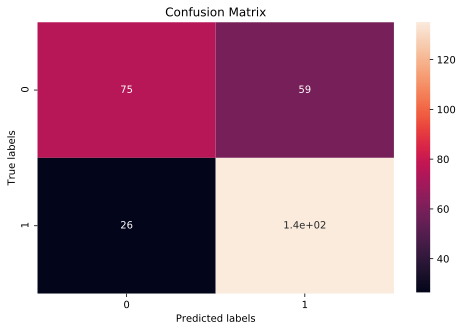

In [60]:
eclf1 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('knn', knnModel), 
                                     ('lg', lgModel),], 
                                     voting='hard')
eclf1 = eclf1.fit(normalized_train_dataset, train_target)

eclf2 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('knn', knnModel),
                                     ('lg', lgModel)],
                                     voting='soft')
eclf2 = eclf2.fit(normalized_train_dataset, train_target)

eclf3 = VotingClassifier(estimators=[('RDF',RDF_grid_model),('knn', knnModel), 
                                     ('lg', lgModel),],
                                    voting='soft', flatten_transform=True)
eclf3 = eclf3.fit(normalized_train_dataset, train_target)

print(eclf1.score( normalized_train_dataset, train_target))
print(eclf2.score( normalized_train_dataset, train_target))
print(eclf3.score( normalized_train_dataset, train_target),'\n')

print(eclf1.score( normalized_test_dataset, test_target))
print(eclf2.score( normalized_test_dataset, test_target))
print(eclf3.score( normalized_test_dataset, test_target),'\n')

# Score.append(max(eclf1.score( normalized_test_dataset, test_target),
#                            eclf2.score( normalized_test_dataset, test_target),
#                            eclf3.score( normalized_test_dataset, test_target)))
expected = test_target
predicted_VotingClassifier3 = eclf3.predict(normalized_test_dataset)

#---------------------------------------------------------------------
#Отрисовка confusion_matrix
cm = metrics.confusion_matrix(expected, predicted_VotingClassifier3)
print(cm)
spec1=cm[0][0]/(cm[0][0]+cm[0][1])
spec.append(spec1)
ch1=cm[1][1]/(cm[1][0]+cm[1][1])
ch.append(ch1)
print('Специфичность',spec1)
print('Чувствительность',ch1)
print('--------------')

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax);
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
# ax.xaxis.set_ticklabels(['О', 'К']); 
# ax.yaxis.set_ticklabels(['О', 'К']);
#--------------------------------------------------------------------
#Результаты
f1ScoreWeighted_VotingClassifier3=f1_score(test_target, predicted_VotingClassifier3, average='weighted')
print("f1ScoreWeighted=",f1ScoreWeighted_VotingClassifier3)

f1ScoreMacro_VotingClassifier3=f1_score(test_target, predicted_VotingClassifier3, average='macro')
print("f1ScoreMacro=",f1ScoreMacro_VotingClassifier3)
      
f1ScoreBinary_VotingClassifier3=f1_score(test_target, predicted_VotingClassifier3, average='binary')
print("f1ScoreBinary=",f1ScoreBinary_VotingClassifier3)

buff_score=eclf3.score(normalized_test_dataset, test_target)
Score.append(buff_score)
print('Точноть',buff_score)
NameModel.append("VotingClassifier3")
save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
if save==True:
    with open(name, 'wb') as fid:
        pickle.dump(eclf3, fid)

In [61]:
# from sklearn import linear_model
# stacker_Ridge= linear_model.RidgeClassifier()


# df = np.append(predicted_RDF_grid_train.reshape(686,1), predicted_NuSVC2_train.reshape(686,1), axis=1)
# df = np.append(df, predicted_cartModel_train.reshape(686,1), axis=1)
# df = np.append(df, predicted_lgModel_train.reshape(686,1), axis=1)
# df = np.append(df, predicted_knnModel_train.reshape(686,1), axis=1)
# # df = train_target

# test_dataframe = np.append(predicted_RDF.reshape(295,1), predicted_NuSVC2.reshape(295,1), axis=1)
# test_dataframe = np.append(test_dataframe, predicted_cartModel.reshape(295,1), axis=1)
# test_dataframe = np.append(test_dataframe, predicted_lgModel.reshape(295,1), axis=1)
# test_dataframe = np.append(test_dataframe, predicted_knnModel.reshape(295,1), axis=1)

# stacker_Ridge.fit(df, train_target)
# expected = test_target
# predicted_stacker_Ridge = stacker_Ridge.predict(test_dataframe)

# #---------------------------------------------------------------------
# #Отрисовка confusion_matrix
# cm = metrics.confusion_matrix(test_target, predicted_stacker_Ridge)
# print(cm)
# spec1=cm[0][0]/(cm[0][0]+cm[0][1])
# spec.append(spec1)
# ch1=cm[1][1]/(cm[1][0]+cm[1][1])
# ch.append(ch1)
# print('Специфичность',spec1)
# print('Чувствительность',ch1)
# print('--------------')

# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax);
# ax.set_xlabel('Predicted labels');
# ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
# # ax.xaxis.set_ticklabels(['К', 'О']); 
# # ax.xaxis.set_ticklabels(['К', 'О']); 
# #--------------------------------------------------------------------
# #Результаты
# f1ScoreWeighted_stacker_Ridge=f1_score(test_target, predicted_stacker_Ridge, average='weighted')
# print("f1ScoreWeighted=",f1ScoreWeighted_stacker_Ridge)

# f1ScoreMacro_stacker_Ridge=f1_score(test_target, predicted_stacker_Ridge, average='macro')
# print("f1ScoreMacro=",f1ScoreMacro_stacker_Ridge)
      
# f1ScoreBinary_stacker_Ridge=f1_score(test_target, predicted_stacker_Ridge, average='binary')
# print("f1ScoreBinary=",f1ScoreBinary_stacker_Ridge)

# buff_score=stacker_Ridge.score(test_dataframe, test_target)
# Score.append(buff_score)
# NameModel.append("stacker_Ridge")
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(stacker_Ridge, fid)

In [62]:
# from sklearn import linear_model
# stacker_LG= linear_model.LogisticRegression()


# df = np.append(predicted_RDF_grid_train.reshape(686,1), predicted_NuSVC2_train.reshape(686,1), axis=1)
# df = np.append(df, predicted_cartModel_train.reshape(686,1), axis=1)
# df = np.append(df, predicted_lgModel_train.reshape(686,1), axis=1)
# df = np.append(df, predicted_knnModel_train.reshape(686,1), axis=1)
# # df = train_target

# test_dataframe = np.append(predicted_RDF.reshape(295,1), predicted_NuSVC2.reshape(295,1), axis=1)
# test_dataframe = np.append(test_dataframe, predicted_cartModel.reshape(295,1), axis=1)
# test_dataframe = np.append(test_dataframe, predicted_lgModel.reshape(295,1), axis=1)
# test_dataframe = np.append(test_dataframe, predicted_knnModel.reshape(295,1), axis=1)

# print('len test_dataframe=',len(test_dataframe))
# stacker_LG.fit(df, train_target)
# expected = test_target
# predicted_stacker_LG = stacker_LG.predict(test_dataframe)

# #---------------------------------------------------------------------
# #Отрисовка confusion_matrix
# cm = metrics.confusion_matrix(test_target, predicted_stacker_LG)
# print(cm)
# spec1=cm[0][0]/(cm[0][0]+cm[0][1])
# spec.append(spec1)
# ch1=cm[1][1]/(cm[1][0]+cm[1][1])
# ch.append(ch1)
# print('Специфичность',spec1)
# print('Чувствительность',ch1)
# print('--------------')  

# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax);
# ax.set_xlabel('Predicted labels');
# ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
# # ax.xaxis.set_ticklabels(['К', 'О']); 
# # ax.xaxis.set_ticklabels(['К', 'О']); 
# #--------------------------------------------------------------------
# #Результаты
# f1ScoreWeighted_stacker_LG=f1_score(test_target, predicted_stacker_LG, average='weighted')
# print("f1ScoreWeighted=",f1ScoreWeighted_stacker_LG)

# f1ScoreMacro_stacker_LG=f1_score(test_target, predicted_stacker_LG, average='macro')
# print("f1ScoreMacro=",f1ScoreMacro_stacker_LG)
      
# f1ScoreBinary_stacker_LG=f1_score(test_target, predicted_stacker_LG, average='binary')
# print("f1ScoreBinary=",f1ScoreBinary_stacker_LG)

# buff_score=stacker_LG.score(test_dataframe, test_target)
# print('Точноть',buff_score)
# Score.append(buff_score)
# NameModel.append("stacker Log Reg")
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(stacker_LG, fid)

In [63]:
# #GridSearchCV
# tuned_parameters= list(range(1,30))
# stacker_knnModel = KNeighborsClassifier()
# grid = GridSearchCV(stacker_knnModel, param_grid={'n_neighbors': tuned_parameters},cv=5)
# grid.fit(df, train_target)

# best_cv_err = 1 - grid.best_score_
# best_n_neighbors = grid.best_estimator_.n_neighbors
# print (best_cv_err, best_n_neighbors,"\n")
# #----------------------------------------------------------------------
# #Обучение модели с оптимальными параметрами
# # from sklearn.preprocessing import StandardScaler 
# # scaler = StandardScaler() 
# # X_train_scaled = scaler.fit_transform(df) 
# # X_test_scaled = scaler.transform(test_dataframe) 

# stacker_knnModel = KNeighborsClassifier(n_neighbors=best_n_neighbors)
# stacker_knnModel.fit(df, train_target)
# # arr = np.reshape(arr, arr.shape + (1,))
# expected = test_target
# stacker_predicted_knnModel=stacker_knnModel.predict(test_dataframe)

# #---------------------------------------------------------------------
# #Отрисовка confusion_matrix
# cm = metrics.confusion_matrix(test_target, stacker_predicted_knnModel)
# print(cm)
# spec1=cm[0][0]/(cm[0][0]+cm[0][1])
# spec.append(spec1)
# ch1=cm[1][1]/(cm[1][0]+cm[1][1])
# ch.append(ch1)
# print('Специфичность',spec1)
# print('Чувствительность',ch1)
# print('--------------')  

# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax);
# ax.set_xlabel('Predicted labels');
# ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix'); 
# # ax.xaxis.set_ticklabels(['К', 'О']); 
# # ax.xaxis.set_ticklabels(['К', 'О']); 
# #--------------------------------------------------------------------
# #Результаты
# f1ScoreWeighted_knnModel=f1_score(test_target, stacker_predicted_knnModel, average='weighted')
# print("f1ScoreWeighted=",f1ScoreWeighted_knnModel)

# f1ScoreMacro_knnModel=f1_score(test_target, stacker_predicted_knnModel, average='macro')
# print("f1ScoreMacro=",f1ScoreMacro_knnModel)
      
# f1ScoreBinary_knnModel=f1_score(test_target, stacker_predicted_knnModel, average='binary')
# print("f1ScoreBinary=",f1ScoreBinary_knnModel)

# buff_score=stacker_knnModel.score(test_dataframe, test_target)
# Score.append(buff_score)
# NameModel.append("stackerknnModel")
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(stacker_knnModel, fid)


In [64]:
# from keras.models import Sequential
# from keras.layers import Dense, Activation,Dropout
# model = Sequential()
# model.add(Dense(32, activation='relu', input_dim=5))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(1, activation='sigmoid'))
# model.compile(optimizer='rmsprop',
#               loss='binary_crossentropy',
#               metrics=['accuracy'])


# model.fit(df, train_target, epochs=75, batch_size=12)
# scores = model.evaluate(test_dataframe, test_target, verbose=0) 
# print("Точность работы на тестовых данных: %.2f%%" % (scores[1]*100))

In [65]:
# #GridSearchCV 
# from sklearn.neural_network import MLPClassifier 
# tuned_parameters= ((5,2),(10,2),(15,2),(20,2),(25,2),(30,2),(35,2),(40,2),(45,2),(50,2),(55,2),(60,2)) 
# MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1) 
# grid = GridSearchCV(MLP, param_grid={'hidden_layer_sizes': tuned_parameters},cv=5) 
# grid.fit(df, train_target) 

# best_cv_err = 1 - grid.best_score_ 
# best_hidden_layer_sizes = grid.best_estimator_.hidden_layer_sizes 
# print (best_cv_err, best_hidden_layer_sizes,"\n") 
# #--------------------------------------------------------------------— 
# #Обучение модели с оптимальными параметрами 

# MLP = MLPClassifier(solver='lbfgs', alpha=1e-5, 
# hidden_layer_sizes=best_hidden_layer_sizes, random_state=1) 
# MLP.fit(df, train_target) 

# expected = test_target 
# predicted = MLP.predict(test_dataframe) 
# MLP.score(test_dataframe, test_target)
# print(MLP.score(test_dataframe, test_target))
# #---------------------------------------------------------------------
# f1ScoreWeighted=f1_score(test_target, predicted, average='weighted') 
# print("f1ScoreWeighted=",f1ScoreWeighted) 

# f1ScoreMacro=f1_score(test_target, predicted, average='macro') 
# print("f1ScoreMacro=",f1ScoreMacro) 

# f1ScoreBinary=f1_score(test_target, predicted, average='binary') 
# print("f1ScoreBinary=",f1ScoreBinary)

In [66]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.metrics import roc_auc_score         
# #----------------------------------------------------------------------
# #GridSearchCV
# stacker_RDF = RandomForestClassifier()
# tuned_parameters={'n_estimators': np.arange(10,100),'max_features':np.arange(1,5)}
# grid = GridSearchCV(stacker_RDF, param_grid=tuned_parameters,cv=5)
# grid.fit(df, train_target)

# best_cv_err = 1 - grid.best_score_
# best_n_estimators = grid.best_estimator_.n_estimators
# best_max_features = grid.best_estimator_.max_features
# print ('err=',best_cv_err, " best_n_estimators=",best_n_estimators, " max_features=",best_max_features,"\n")

# #----------------------------------------------------------------------

# stacker_RDF_grid = RandomForestClassifier(n_estimators=best_n_estimators,max_features=best_max_features,oob_score=True,)
# stacker_RDF_grid.fit(df, train_target)

# predicted_RDF = stacker_RDF_grid.predict(test_dataframe)

# #---------------------------------------------------------------------
# #Отрисовка confusion_matrix
# cm = metrics.confusion_matrix(expected, predicted_RDF)
# print(cm)
# spec1=cm[0][0]/(cm[0][0]+cm[0][1])
# spec.append(spec1)
# ch1=cm[1][1]/(cm[1][0]+cm[1][1])
# ch.append(ch1)
# print('Специфичность',spec1)
# print('Чувствительность',ch1)
# print('--------------') 

# ax= plt.subplot()
# sns.heatmap(cm, annot=True, ax = ax);
# ax.set_xlabel('Predicted labels');
# ax.set_ylabel('True labels'); 
# ax.set_title('Confusion Matrix');
# # ax.xaxis.set_ticklabels(['К', 'О']); 
# # ax.xaxis.set_ticklabels(['К', 'О']); 
# #--------------------------------------------------------------------
# #Результаты
# f1ScoreWeighted=f1_score(test_target, predicted_RDF, average='weighted')
# print("f1ScoreWeighted=",f1ScoreWeighted)

# f1ScoreMacro=f1_score(test_target, predicted_RDF, average='macro')
# print("f1ScoreMacro=",f1ScoreMacro)
      
# f1ScoreBinary=f1_score(test_target, predicted_RDF, average='binary')
# print("f1ScoreBinary=",f1ScoreBinary)

# buff_score=stacker_RDF_grid.score(test_dataframe, test_target)
# Score.append(buff_score)
# NameModel.append("stacker_RDF_grid")
# save,name=saveModel(Score[len(Score)-1],path,NameModel[len(NameModel)-1])
# if save==True:
#     with open(name, 'wb') as fid:
#         pickle.dump(stacker_RDF_grid, fid)

No handles with labels found to put in legend.


[0.5694915254237288, 0.6271186440677966, 0.6372881355932203, 0.6440677966101694, 0.5864406779661017, 0.535593220338983, 0.688135593220339, 0.6949152542372882, 0.711864406779661]
['nuSVC', 'cartModel', 'lgModel', 'knnModel', 'RDF', 'nbModel', 'VotingClassifier1', 'VotingClassifier2', 'VotingClassifier3']


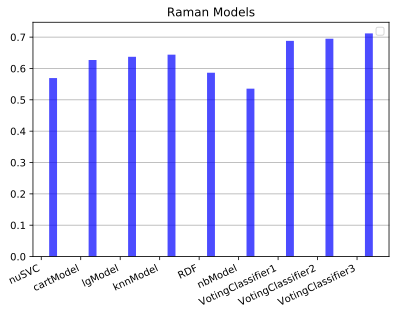

In [67]:
print(Score)
print(NameModel)
# Score=[0.6649484536082475, 0.6925064599483205, 0.7614213197969544, 0.6577181208053692, 0.6909090909090908, 0.555979381443296]
# NameModel=['SVC', 'CART', 'LR', 'KNN','RDF','NB']
# Score=[0.6649484536082475, 0.6925064599483205, 0.7614213197969544, 0.6577181208053692, 0.6909090909090908, 0.28865979381443296, 0.7520000000000001, 0.7365269461077845, 0.8010471204188482, 0.6909090909090908, 0.7152941176470589, 0.702127659574468, 0.7136150234741784]
# NameModel=['nuSVC', 'cartModel', 'lgModel', 'knnModel', 'RDF', 'nbModel', 'VotingClassifier1', 'VotingClassifier2', 'VotingClassifier3', 'stacker_Ridge', 'stacker Log Reg', 'stackerknnModel', 'stacker_RDF_grid']

from pandas import date_range,Series,DataFrame,read_csv, qcut
from numpy.random import rand

#df2 = pd.DataFrame(a, columns=['NameModel'])
#df2.plot(kind='bar');

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})
plt.title('Raman Models')
ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)
xs = range(len(NameModel))
plt.bar([x + 0.3 for x in xs], Score,
        width = 0.2, color = 'blue', alpha = 0.7,
        zorder = 2)
plt.xticks(xs,NameModel)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
fig.savefig('Score.png')

No handles with labels found to put in legend.


[17.91044776119403, 88.05970149253731, 37.3134328358209, 76.11940298507463, 32.08955223880597, 96.26865671641791, 82.83582089552239, 82.83582089552239, 55.970149253731336]


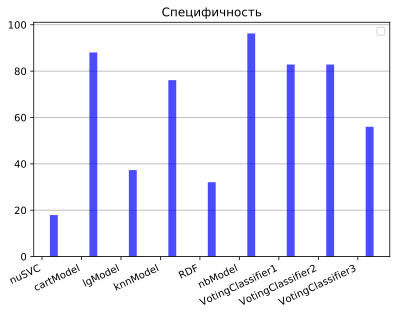

In [68]:
spec=[i * 100 for i in spec]
print(spec)
from pandas import date_range,Series,DataFrame,read_csv, qcut
from numpy.random import rand

#df2 = pd.DataFrame(a, columns=['NameModel'])
#df2.plot(kind='bar');

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})
plt.title('Специфичность')
ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)
xs = range(len(NameModel))
plt.bar([x + 0.3 for x in xs], spec,
        width = 0.2, color = 'blue', alpha = 0.7,
        zorder = 2)
plt.xticks(xs,NameModel)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
fig.savefig('spec.png')

[89.44099378881988, 41.61490683229814, 85.71428571428571, 54.6583850931677, 80.74534161490683, 18.012422360248447, 57.14285714285714, 57.14285714285714, 83.85093167701864]


No handles with labels found to put in legend.


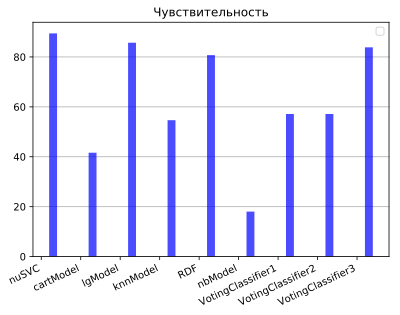

In [69]:
ch=[i * 100 for i in ch]
print(ch)
from pandas import date_range,Series,DataFrame,read_csv, qcut
from numpy.random import rand

#df2 = pd.DataFrame(a, columns=['NameModel'])
#df2.plot(kind='bar');

dpi = 80
fig = plt.figure(dpi = dpi, figsize = (512 / dpi, 384 / dpi) )
mpl.rcParams.update({'font.size': 10})
plt.title('Чувствительность')
ax = plt.axes()
ax.yaxis.grid(True, zorder = 1)
xs = range(len(NameModel))
plt.bar([x + 0.3 for x in xs], ch,
        width = 0.2, color = 'blue', alpha = 0.7,
        zorder = 2)
plt.xticks(xs,NameModel)

fig.autofmt_xdate(rotation = 25)

plt.legend(loc='upper right')
fig.savefig('ch.png')